<h1>Image Data Generator test\
Watching from above

## Team composition:
* **Fabrice**
* **Ludovica**
* **Luis**
* **Pablo**
* **Rui**

# Notebook preparation 

## Packages
--> Install the necessary packages in the new environment

* pip install tensorflow
* pip install tdqm

## librairies import

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm # to observ the progression
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt

# Data preparation

## Load data 

In [3]:
os.getcwd()

'/home/fabrice.deustachio/code/pabloknecht/watching-from-above/notebooks'

In [4]:
data_path = '../raw_data/EuroSAT'

classes_name = os.listdir(os.path.join(data_path))

f'Number of classes : {len(classes_name)} '

'Number of classes : 10 '

## Balance / Unbalance checking 
--> (number images per category)

In [5]:
for i in range(len(classes_name)):
    images_per_cat = os.listdir(os.path.join(data_path, classes_name[i]))
    print(
        f'{classes_name[i]} :   {len(images_per_cat)} images'
        )    

River :   2500 images
Forest :   3000 images
Residential :   3000 images
Highway :   2500 images
Pasture :   2000 images
PermanentCrop :   2500 images
AnnualCrop :   3000 images
SeaLake :   3000 images
Industrial :   2500 images
HerbaceousVegetation :   3000 images


**Dataset already balanced = No action**

## Dataset conversion with labels encoding

In [6]:
def conv_data():
    
    classes = {
            'AnnualCrop':0,
            'Forest':1, 
            'HerbaceousVegetation':2,
            'Highway':3,
            'Industrial':4,
            'Pasture':5,
            'PermanentCrop':6,
            'Residential':7,
            'River':8,
            'SeaLake':9,
            }
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:3000]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                if image.size != (64,64):
                    print(f'error size {img}')
                image = image.resize((64, 64))
                imgs.append(np.array(image))
                labels.append(i)
    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)
    
    # Shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]
    
    return X, y, imgs

In [8]:
X, y, imgs = conv_data()

100%|██████████| 3000/3000 [00:00<00:00, 3506.54it/s]


Let's check the datas format after loading (and also encoding for y) :

In [9]:
print("______________Check X________________________")
print(f'X shape : {X.shape},min X value is : {np.min(X)}, Max X value is : {np.max(X)} ')
print("______________Check y _______________________")
print(f'y shape : {y.shape}')

______________Check X________________________
X shape : (27000, 64, 64, 3),min X value is : 0, Max X value is : 255 
______________Check y _______________________
y shape : (27000, 10)


2499
4998
7497
9996
12495
14994
17493
19992
22491
24990


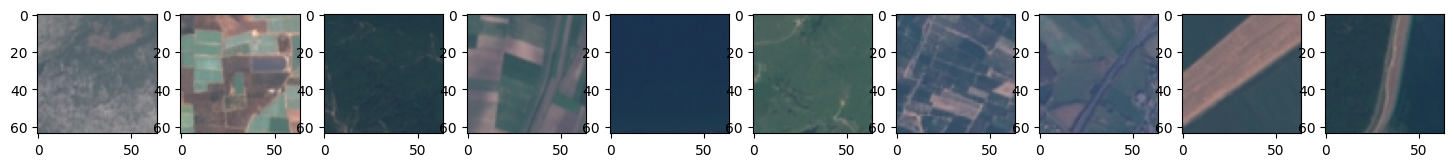

In [10]:
k=0
plt.figure(figsize=(20,15))
for i in range(len(classes_name)):
    plt.subplot(1,11, i+1)
    img = np.squeeze(X[k])
    plt.imshow(img, cmap='gray')
    k+=2499
    
    print(k)


## Train & test split :

In [11]:
    first_split = int(len(imgs) * 0.2) # X_tests = 10% 
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    print(f'X_train shape : {X_train.shape},X_val shape : {X_val.shape}, X_test shape : {X_test.shape}')
    print(f'y_train shape : {y_train.shape},y_val shape : {y_val.shape},  y_test shape : {y_test.shape}')

X_train shape : (16200, 64, 64, 3),X_val shape : (5400, 64, 64, 3), X_test shape : (5400, 64, 64, 3)
y_train shape : (16200, 10),y_val shape : (5400, 10),  y_test shape : (5400, 10)


## !!!!   ImageDataGenerator !!!!

In [28]:
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_datagen = ImageDataGenerator(
                             #rescale=1/255,
                             brightness_range=[0.4,0.9],
                             rotation_range=20,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             horizontal_flip=True,
                             shear_range=0.2,
                             #zoom_range=0.2,
                             )

In [29]:
augmented_datagen.fit(X_train)

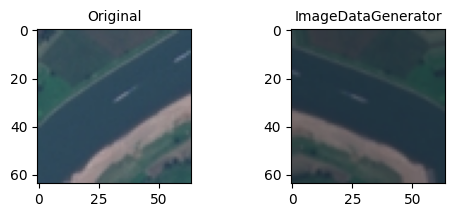

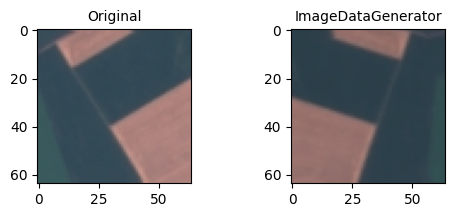

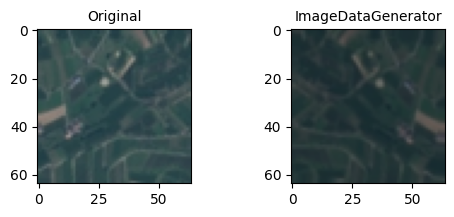

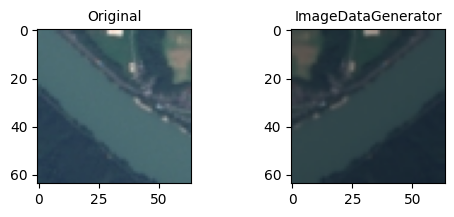

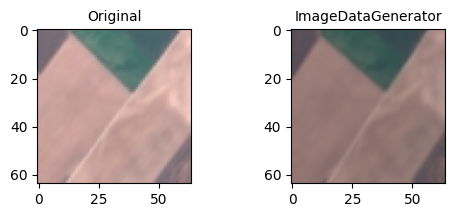

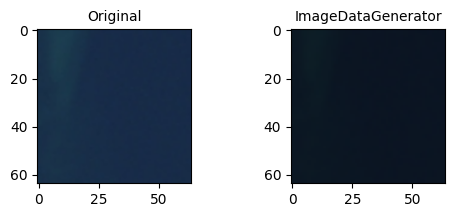

In [30]:
#Just for plotting, training_generator have to be updated atfer plotting !
training_generator = augmented_datagen.flow(X_train,y_train, batch_size=1, shuffle=False)

#For loop for having a look on pictures comparison :
for i, (original_image, augmented_image) in enumerate(zip(X_train, training_generator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow((original_image).astype(np.uint8))
    ax1.set_title("Original", fontsize=10)
    ax2.imshow((augmented_image[0]).reshape(64,64,3).astype(np.uint8))
    ax2.set_title("ImageDataGenerator", fontsize=10)
    plt.show()
    
    if i > 4:
        break

In [14]:
# For others datas except Train :
#datagen = ImageDataGenerator(rescale=1./255)

In [31]:
training_generator = augmented_datagen.flow(X_train,y_train, batch_size=64, seed=7)
#validation_generator = datagen.flow(X_val,y_val, batch_size=54, seed=7)
#test_generator = datagen.flow(X_test,y_test, batch_size=64, seed=7)

In [32]:
X_val.shape

(5400, 64, 64, 3)

In [44]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def evo_model():
    
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=(64,64,3)))
    
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding='same', activation='relu',input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D(pool_size=(3,3)))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(32, kernel_size=(2,2), padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, kernel_size=(2,2), padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [45]:
model_evo = evo_model()
model_evo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        1216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 21, 21, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 32)        2080      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                 

In [59]:
def fit_model(model_evo, training_generator, X_val,y_val):
 
  es = EarlyStopping(monitor = 'val_accuracy', 
                   patience = 20, 
                   restore_best_weights = True,
                   verbose = 1 )
                   
  
  history = model.fit(  training_generator,
                        #steps_per_epoch=100,
                        batch_size = 64, 
                        epochs=150,
                        validation_data=(X_val, y_val),
                        #validation_steps=100,
                        callbacks=[es])
  
  
  return history

In [60]:
history = fit_model(model_evo, training_generator, X_val,y_val)

Epoch 1/150
254/254 [==============================] - 82s 324ms/step - loss: 0.8220 - accuracy: 0.7030 - val_loss: 1.1249 - val_accuracy: 0.6393
Epoch 2/150
254/254 [==============================] - 84s 330ms/step - loss: 0.8245 - accuracy: 0.7014 - val_loss: 1.1568 - val_accuracy: 0.6283
Epoch 3/150
254/254 [==============================] - 82s 323ms/step - loss: 0.8025 - accuracy: 0.7116 - val_loss: 0.9527 - val_accuracy: 0.6791
Epoch 4/150
254/254 [==============================] - 81s 320ms/step - loss: 0.8054 - accuracy: 0.7088 - val_loss: 0.9301 - val_accuracy: 0.6859
Epoch 5/150
254/254 [==============================] - 86s 337ms/step - loss: 0.7888 - accuracy: 0.7166 - val_loss: 0.9871 - val_accuracy: 0.6778
Epoch 6/150
254/254 [==============================] - 86s 337ms/step - loss: 0.7921 - accuracy: 0.7167 - val_loss: 1.0973 - val_accuracy: 0.6504
Epoch 7/150
254/254 [==============================] - 87s 342ms/step - loss: 0.7869 - accuracy: 0.7143 - val_loss: 0.9641 -

In [62]:

from tensorflow.keras import models
model_path = '../models/ImageDataGenerator_Fab'
models.save_model(model_evo, model_path)


#model = model.load_model(evo_model_ImageDataGenerator')

#Example
#model.save('model_trained_enhanced.h5')
#model = model.load_model('model_trained_enhanced.h5')

INFO:tensorflow:Assets written to: ../models/ImageDataGenerator_Fab/assets


INFO:tensorflow:Assets written to: ../models/ImageDataGenerator_Fab/assets


**Loss & accuracy (train/val):**

In [16]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

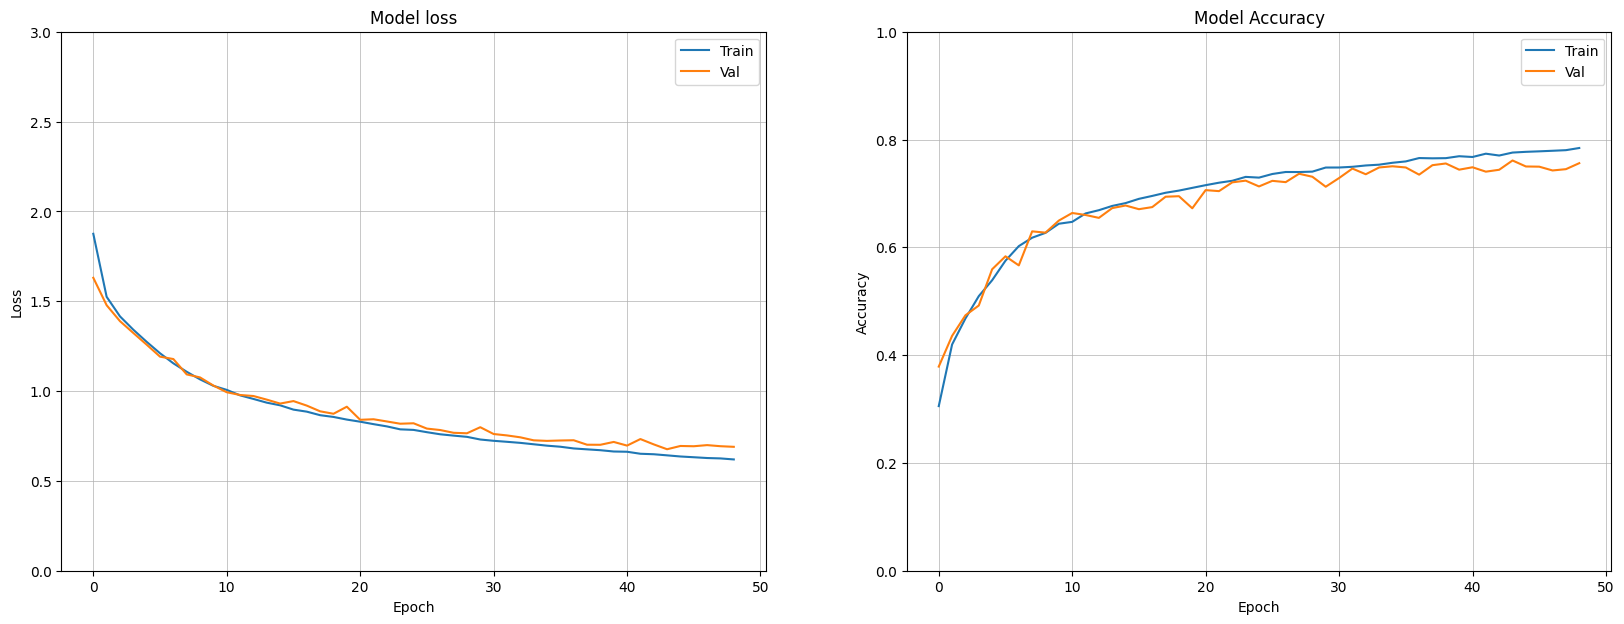

In [17]:
plot_loss_accuracy(history)

**Model evaluation:**

In [18]:
evaluation = model_basic.evaluate(X_test, y_test)
evaluation

169/169 [==============================] - 4s 24ms/step - loss: 0.6516 - accuracy: 0.7683


[0.6516298055648804, 0.7683333158493042]

In [19]:
test_accuracy = evaluation[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 77.0 %


In [20]:
os.getcwd()

'/home/ludovica.baldi/code/pabloknecht/watching-from-above/notebooks'

In [51]:
data_path = '../image_Forest.jpg'

In [52]:
X_test2 = []
X_test2.append(np.array(Image.open(data_path)))
X_test2=np.array(X_test2)

In [53]:
X_test2.shape

(1, 64, 64, 3)

In [54]:
pred = model_basic.predict(X_test2)
pred[0][np.argmax(pred)], np.argmax(pred)

1/1 [==============================] - 0s 31ms/step


(0.94258314, 6)

In [56]:
from tensorflow.keras import models
models.save_model(model_basic, 'my_model2')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
loaded = models.load_model('my_model')